# 🌴The Data of Dates: Ajwa or Medjool?🌴
# Modified CNN version

Simon Smith's final project for CS 4710, modified from final project for CS 4700

Thanks to Dr. Ghassan Bati of Umm Al-Qura University in Saudi Arabia for the dataset. I only *barely* manually adjusted some of the images - changing the orientation of 2 or 3 horizonal Ajwa images to vertical so that they would match the rest of the dataset.
  https://www.qscience.com/content/journals/10.5339/jist.2023.12

Thanks to Dr. Chen for her help with this project last semester, and to Larry for his help this semester!

# Setup Instructions
In your Google Drive, upload the provided folder **date_data** (attached in submission)

In [ ]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/My Drive/date_data")

Mounted at /content/drive


# Subsets, Transforms, Load data
Define subsets (train, validation, test)
Perform transforms (resizing for all; data augmentation for train)
Load data

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision import transforms

# Step 1: Load without any transform initially
full_dataset = ImageFolder('./ajwa_medjool_database/') # ('./test_image/')

# Step 2: Split into subsets
train_size = int(0.65 * len(full_dataset))
valid_size = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - valid_size

train_subset, valid_subset, test_subset = random_split(full_dataset, [train_size, valid_size, test_size])

# Step 3: Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Step 4: Assign transforms by wrapping in Subset objects again
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

# Step 5: Wrap each subset
train_dataset = TransformedDataset(train_subset, train_transform)
valid_dataset = TransformedDataset(valid_subset, test_transform)
test_dataset  = TransformedDataset(test_subset, test_transform)

# Step 6: load data
train_dat_load = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dat_load = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dat_load  = DataLoader( test_dataset, batch_size=32, shuffle=False)


#Visualize data (optional)
Compare the augmented training data against non-augmented test data


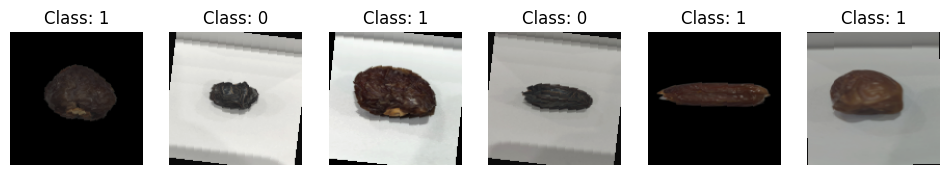

In [ ]:
# visualize augmented images in training dataset
images, labels = next(iter(train_dat_load))

fig, axes = plt.subplots(1, 6, figsize=(12,6))
for i in range(6):
  img = images[i] * 0.5 + 0.5  # unnormalize
  img = img.permute(1, 2, 0).clip(0,1)
  axes[i].imshow(img)
  axes[i].set_title(f"Class: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

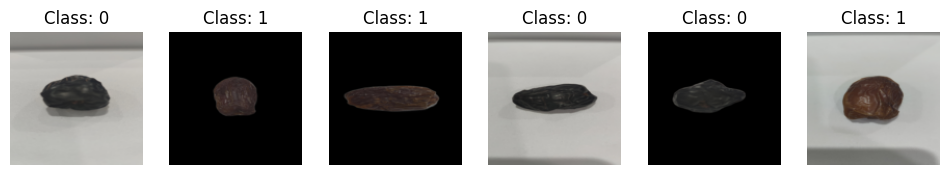

In [ ]:
# show non-augmented images in test dataset
images, labels = next(iter(test_dat_load))

fig, axes = plt.subplots(1, 6, figsize=(12,6))
for i in range(6):
  img = images[i] * 0.5 + 0.5  # unnormalize
  img = img.permute(1, 2, 0).clip(0,1)
  axes[i].imshow(img)
  axes[i].set_title(f"Class: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

#New model with more layers


In [ ]:
dummy_input = torch.ones((1,3,128,128))

# The CNN model, defined by blocks of layers below:
model = nn.Sequential()

# First block
model.add_module('conv1', nn.Conv2d(3, 32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))

# Second block - THIS IS THE NEW LAYER
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))

# Third block
model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(2))

# Generate "flattened_size" for fc1
output = model(dummy_input)
print(f"output shape: {output.shape}")
flattened_size = output.numel()
print(f"flattened size: {flattened_size}")

# Flatten layers, add FC layers
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(flattened_size, 1024))
model.add_module('relu_fc1', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.5))
model.add_module('fc2', nn.Linear(1024, 2))

output shape: torch.Size([1, 128, 16, 16])
flattened size: 32768


In [ ]:
#Loss and Optimizer

# Cross Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train new model

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()

    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)

      is_correct = (
        torch.argmax(pred, dim=1) == y_batch
      ).float()

      accuracy_hist_train[epoch] += is_correct.sum()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

        is_correct = (
            torch.argmax(pred, dim=1) == y_batch
        ).float()

        accuracy_hist_valid[epoch] += is_correct.sum()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val _accuracy: '
          f'{accuracy_hist_valid[epoch]:.4f}')

  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [ ]:
# RESET num_epochs TO 30 EPOCHS FOR REGULARITY BETWEEN TESTS
from time import time

torch.manual_seed(1)
num_epochs = 30
model_start_time = time()
hist = train(model, num_epochs, train_dat_load, valid_dat_load)

# Save as pickle, in case runtime disconnects
with open('./training_pickle/train_results_ML2_more_layers.pkl', 'wb') as f:
    pickle.dump((hist), f)

training_time = time() - model_start_time
print(f'Training time: {int(training_time / 60)} min, {int(training_time%60)} sec')


Epoch 1 accuracy: 0.4846 val _accuracy: 0.5000
Epoch 2 accuracy: 0.5077 val _accuracy: 0.5333
Epoch 3 accuracy: 0.4462 val _accuracy: 0.5000
Epoch 4 accuracy: 0.4692 val _accuracy: 0.5000
Epoch 5 accuracy: 0.5615 val _accuracy: 0.5667
Epoch 6 accuracy: 0.4923 val _accuracy: 0.6000
Epoch 7 accuracy: 0.5538 val _accuracy: 0.5000
Epoch 8 accuracy: 0.5308 val _accuracy: 0.5000
Epoch 9 accuracy: 0.5846 val _accuracy: 0.6000
Epoch 10 accuracy: 0.6308 val _accuracy: 0.9333
Epoch 11 accuracy: 0.6462 val _accuracy: 0.4667
Epoch 12 accuracy: 0.6769 val _accuracy: 0.8667
Epoch 13 accuracy: 0.8154 val _accuracy: 0.9667
Epoch 14 accuracy: 0.9000 val _accuracy: 0.9667
Epoch 15 accuracy: 0.9769 val _accuracy: 0.5333
Epoch 16 accuracy: 0.6769 val _accuracy: 0.6000
Epoch 17 accuracy: 0.7308 val _accuracy: 0.9667
Epoch 18 accuracy: 0.8615 val _accuracy: 0.9667
Epoch 19 accuracy: 0.9769 val _accuracy: 0.9000
Epoch 20 accuracy: 0.9538 val _accuracy: 1.0000
Epoch 21 accuracy: 0.9846 val _accuracy: 1.0000
E

#Visualise Learning Curves



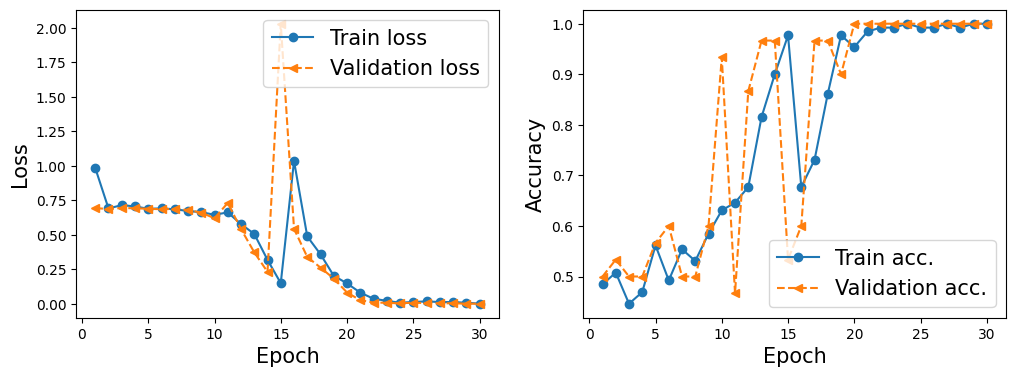

In [ ]:
# Load pickle
with open('./training_pickle/train_results_ML2_more_layers.pkl', 'rb') as f:
    hist = pickle.load(f)


import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

#Evaluate Model on Test Data


In [ ]:
for images, labels in test_dat_load:
  images = images / 225. #normalize
  pred = model(images) #predict
  print(pred.shape)

torch.Size([32, 2])
torch.Size([8, 2])


In [ ]:
# check num correct:
all_predicts = []
all_labels = []

for images, labels in test_dat_load:
  pred = model(images)
  all_predicts.append(torch.argmax(pred, dim=1))
  all_labels.append(labels)

all_predicts = torch.cat(all_predicts)
all_labels = torch.cat(all_labels)

is_correct = (all_predicts == all_labels).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 1.0000


#Visualisation of model predictions of test data


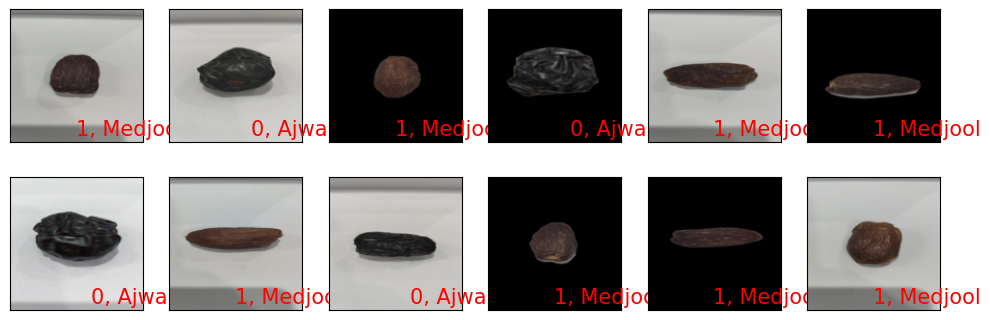

In [ ]:
fit = plt.figure(figsize=(12,4))

for i in range(12):
  ax = fit.add_subplot(2,6,i+1)
  ax.set_xticks([]); ax.set_yticks([])

  img = test_dataset[i][0]

  pred = model(img.unsqueeze(0))
  y_pred = torch.argmax(pred)

  ###
  img_denorm = img * torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) + torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
  ax.imshow(img_denorm.permute(1,2,0).clip(0,1))
  #ax.imshow(img.permute(1,2,0).clip(0,1))

  ax.text(0.9, 0.1, str(y_pred.item()) + ', ' + ['Medjool' if y_pred.item() else 'Ajwa'][0],
          size=15, color='red',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)
plt.show()